The goal of this analysis is to predict the sales in the next 7 days based on historical data

Dataset is available on Kaggle: https://www.kaggle.com/datasets/rohitsahoo/sales-forecasting?datasetId=835308

In [ ]:
import numpy as np
import pandas as pd

# plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm

In [ ]:
df = pd.read_csv('Superstore Sales.csv').drop('Row ID',axis=1)
df.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


# 1. Data cleaning and EDA

In [ ]:
# check the data types and null values. Column "postal code" has one null value - pass.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order ID       9800 non-null   object 
 1   Order Date     9800 non-null   object 
 2   Ship Date      9800 non-null   object 
 3   Ship Mode      9800 non-null   object 
 4   Customer ID    9800 non-null   object 
 5   Customer Name  9800 non-null   object 
 6   Segment        9800 non-null   object 
 7   Country        9800 non-null   object 
 8   City           9800 non-null   object 
 9   State          9800 non-null   object 
 10  Postal Code    9789 non-null   float64
 11  Region         9800 non-null   object 
 12  Product ID     9800 non-null   object 
 13  Category       9800 non-null   object 
 14  Sub-Category   9800 non-null   object 
 15  Product Name   9800 non-null   object 
 16  Sales          9800 non-null   float64
dtypes: float64(2), object(15)
memory usage: 1.3+ MB


In [ ]:
# convert data type
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y') 
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%d/%m/%Y') 
df['Postal Code']=df['Postal Code'].astype('str')

In [ ]:
# remove the decimal point to fix postal code format
df['Postal Code']=df['Postal Code'].str.split('.',expand=True)[0]
df.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,CA-2017-138688,2017-06-12,2017-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [ ]:
#These columns have been successfully converted
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order ID       9800 non-null   object        
 1   Order Date     9800 non-null   datetime64[ns]
 2   Ship Date      9800 non-null   datetime64[ns]
 3   Ship Mode      9800 non-null   object        
 4   Customer ID    9800 non-null   object        
 5   Customer Name  9800 non-null   object        
 6   Segment        9800 non-null   object        
 7   Country        9800 non-null   object        
 8   City           9800 non-null   object        
 9   State          9800 non-null   object        
 10  Postal Code    9800 non-null   object        
 11  Region         9800 non-null   object        
 12  Product ID     9800 non-null   object        
 13  Category       9800 non-null   object        
 14  Sub-Category   9800 non-null   object        
 15  Product Name   9800 n

In [ ]:
df.duplicated().sum()

1

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
categorical_var = df.select_dtypes('object').drop('Order ID',axis=1)

In [ ]:
numerical_var = df.select_dtypes(['int','float'])

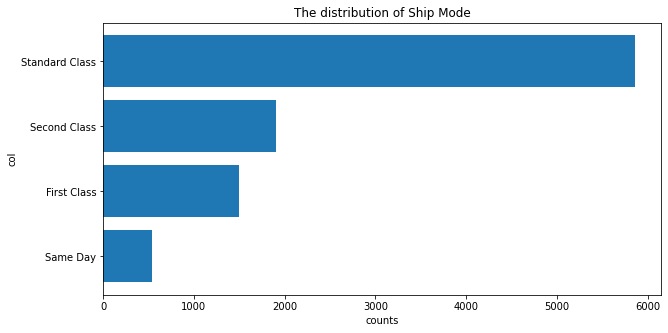

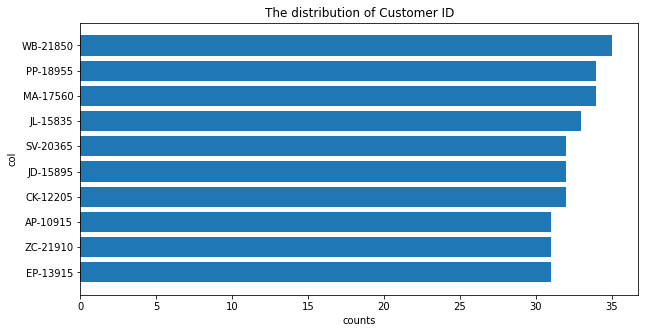

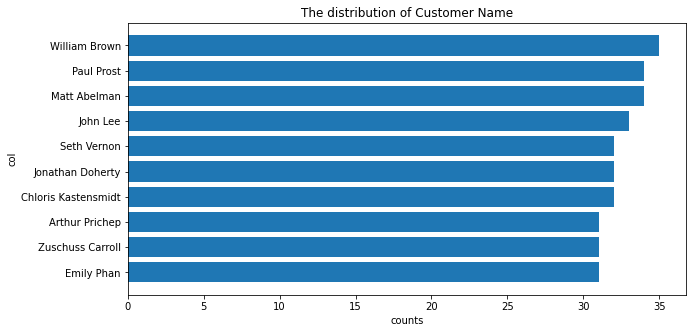

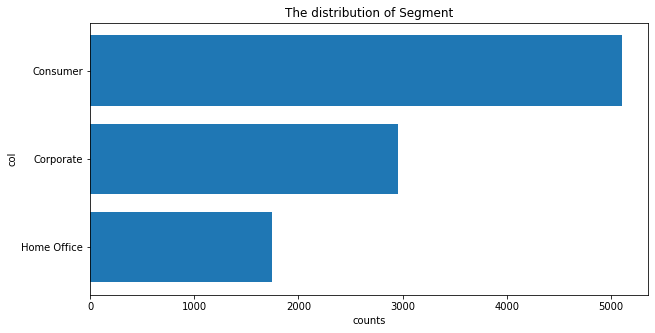

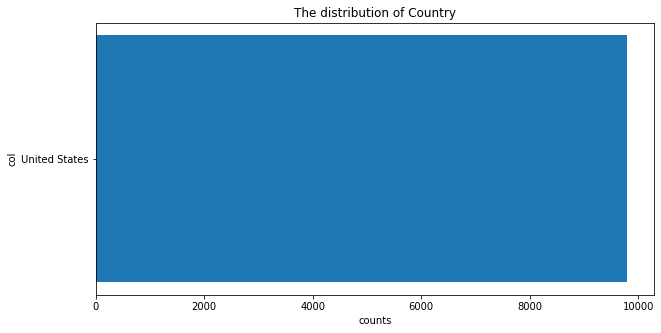

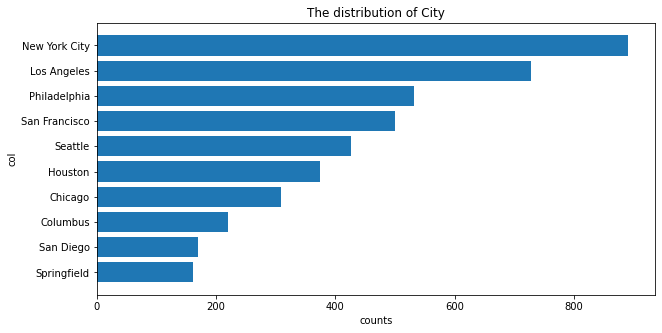

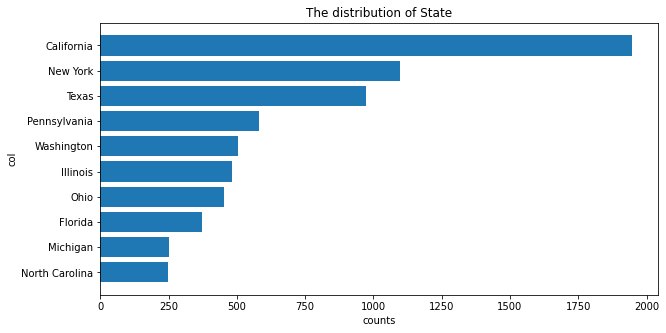

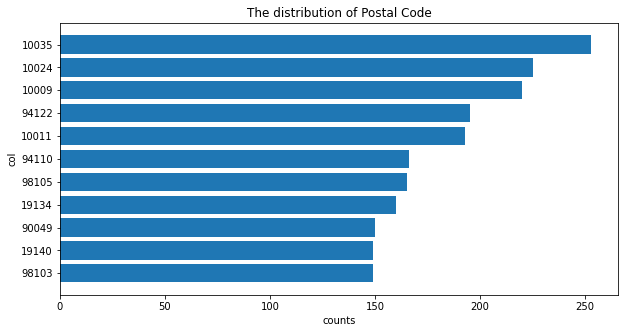

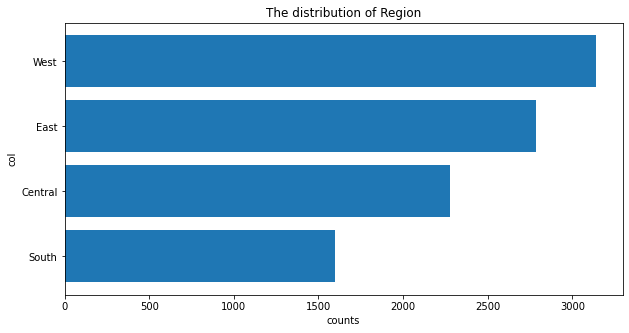

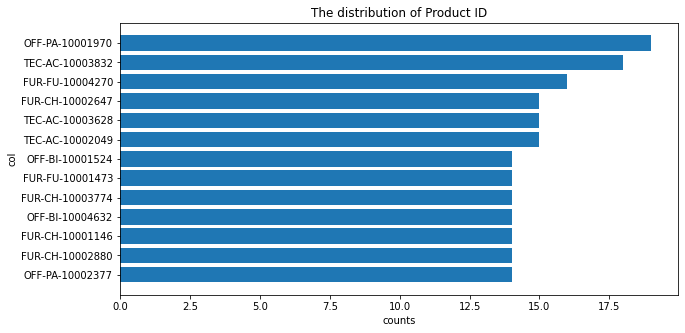

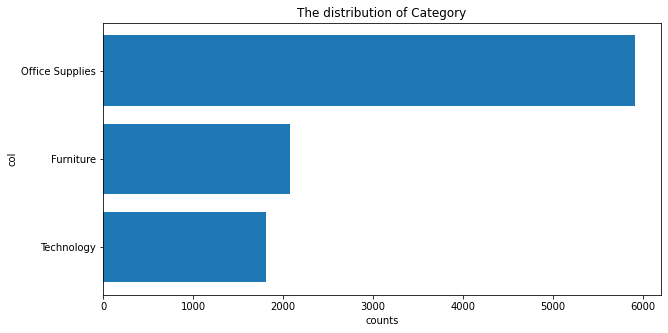

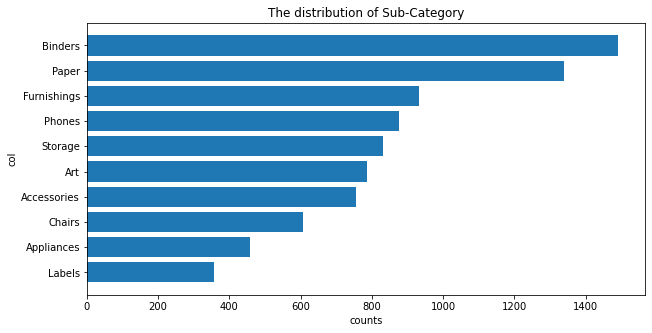

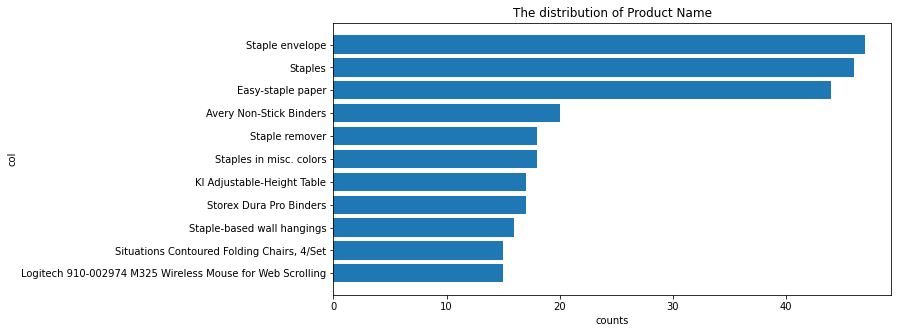

In [ ]:
# plot the distribution of categorical variables
for col in categorical_var:
    cat_value_counts=categorical_var[col].value_counts().nlargest(10,keep='all').sort_values(ascending=True)
    plt.figure(figsize=(10,5))
    plt.barh(cat_value_counts.index,cat_value_counts.values)
    plt.xlabel('counts')
    plt.ylabel(f'col')
    plt.title(f'The distribution of {col}')
    plt.show()

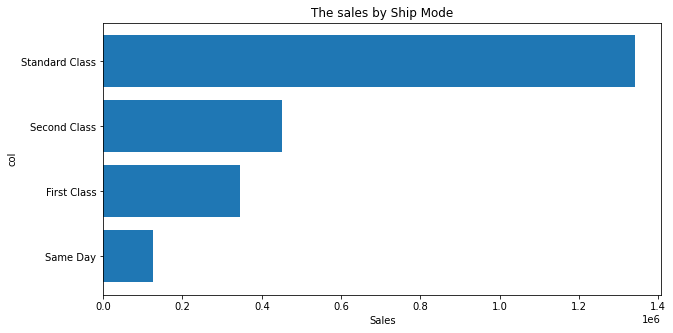

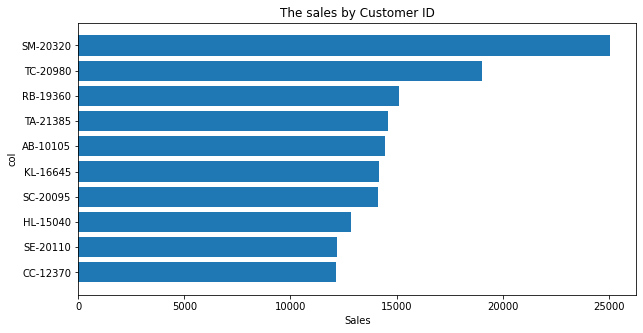

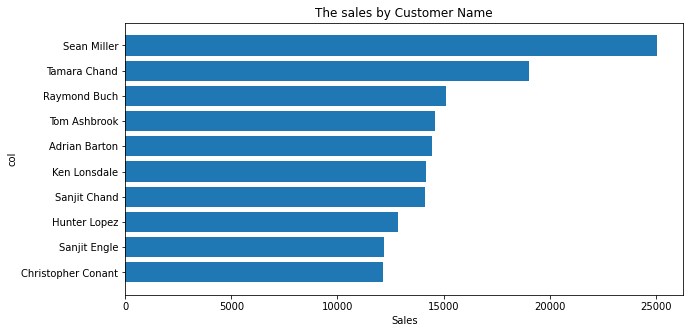

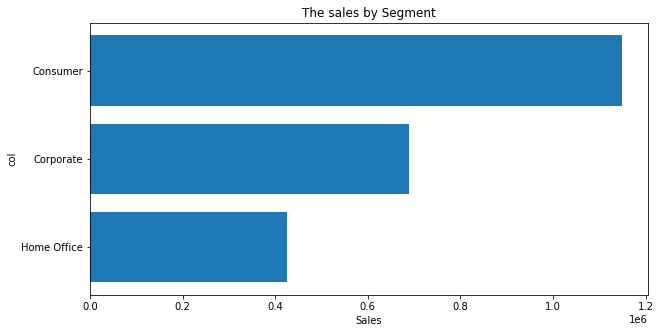

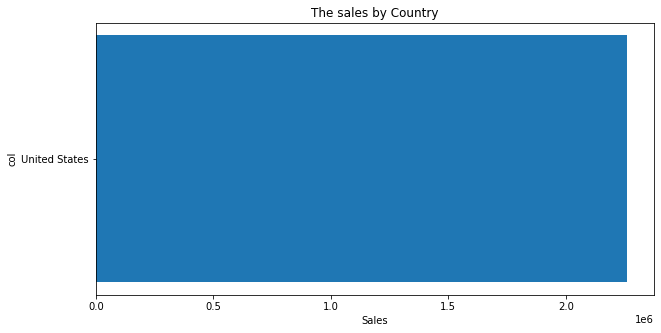

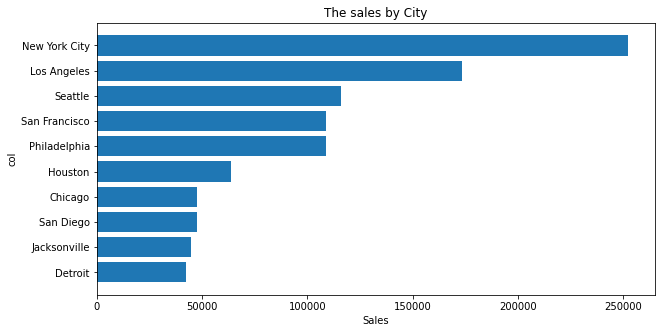

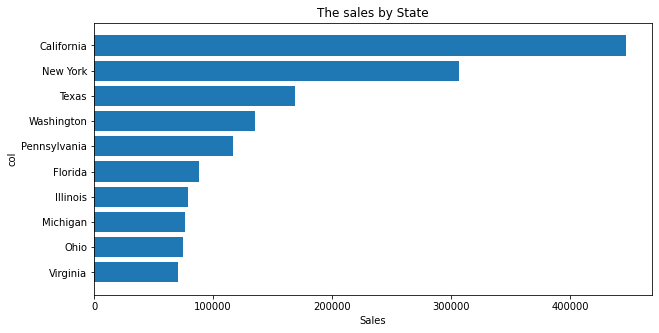

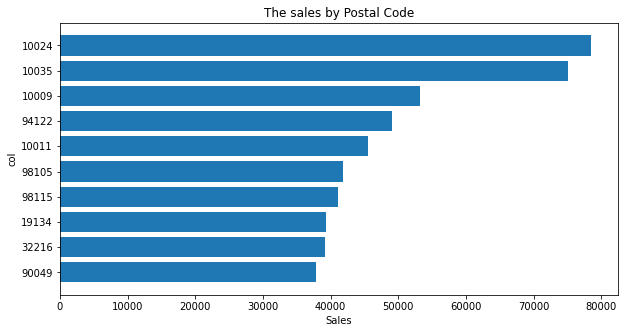

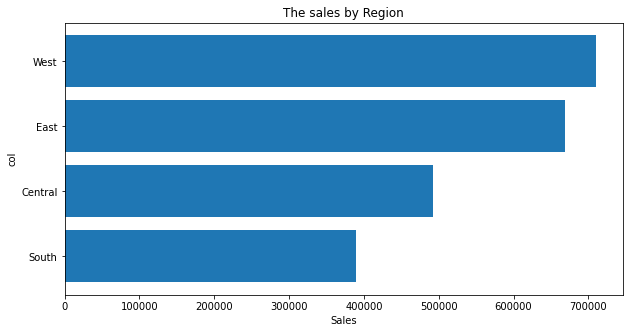

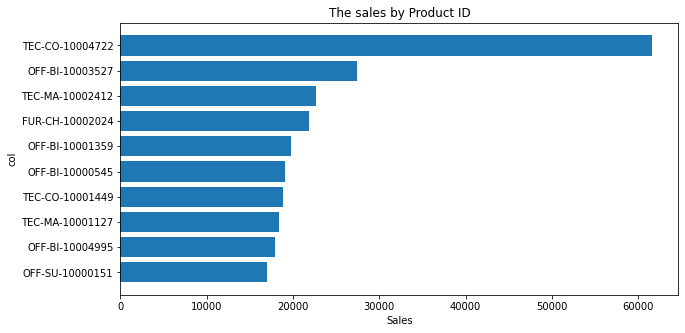

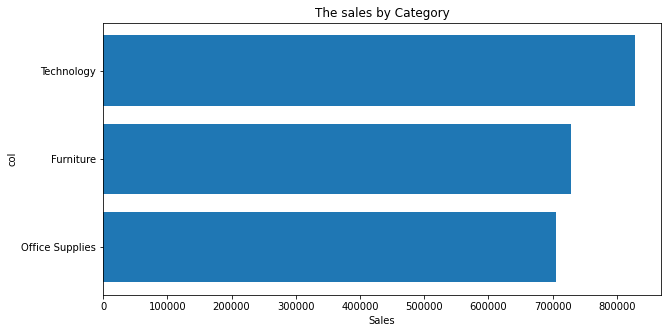

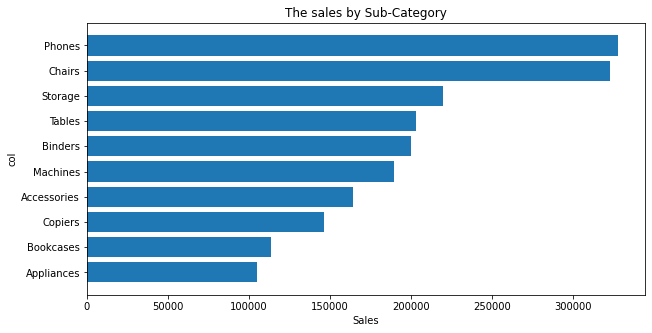

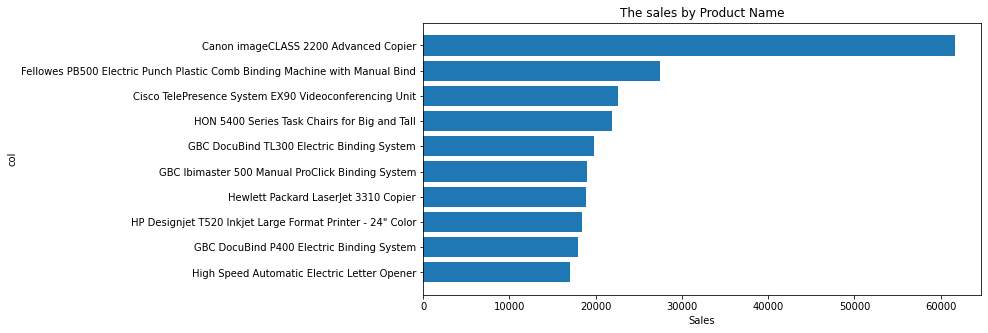

In [ ]:
# plot the sales by categorical variables
for col in categorical_var:
    cat_value_counts=df.groupby(categorical_var[col]).Sales.sum().nlargest(10,keep='all').sort_values()
    plt.figure(figsize=(10,5))
    plt.barh(cat_value_counts.index,cat_value_counts.values)
    plt.xlabel('Sales')
    plt.ylabel(f'col')
    plt.title(f'The sales by {col}')
    plt.show()

* Standard class is the most common ship mode.
* All the sales transactions occurred in US
* New York City had the most sales transactions, followed by Log Angeles
* California had the most sales transactions, followed by New York.
* Region West had the most sales transactions, followed by East
* Staple envelope, staples and easy-staple paper were the most popular product, far more popular than the other products.
* Office supplies was the most category, followed by furnitures
* Binders, paper and furnishings are the top 3 most popular products

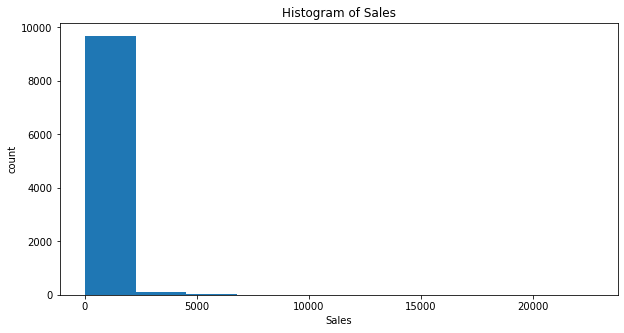

In [ ]:
for col in numerical_var:
    plt.figure(figsize=(10,5))
    plt.hist(numerical_var[col])
    plt.title(f'Histogram of {col}')
    plt.xlabel(f'{col}')
    plt.ylabel('count')
    plt.show()

It appears that most sales revenue are less than $2,500. Adjusted the log scale to make the histogram more readable

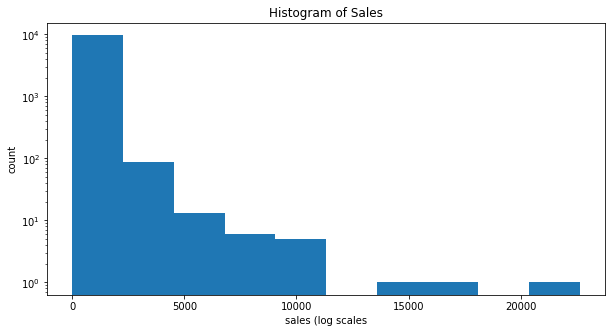

In [ ]:
for col in numerical_var:
    plt.figure(figsize=(10,5))
    plt.hist(numerical_var[col],log=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel('sales (log scales')
    plt.ylabel('count')
    plt.show()

Most sales revenue were less than $2,500 with some exceptions

# 2. Feature Engineering

In [ ]:
df.sort_values(by=['Order Date'], inplace=True, ascending=True)
df.set_index("Order Date", inplace = True)

In [ ]:
daily_df = pd.DataFrame(df['Sales'])

In [ ]:
daily_df = pd.DataFrame(daily_df['Sales'].resample('D').mean())

In [ ]:
daily_df_vis = df.resample('D').mean()

In [ ]:
daily_df_vis.fillna(0,inplace=True)

In [ ]:
daily_df.fillna(0,inplace=True)

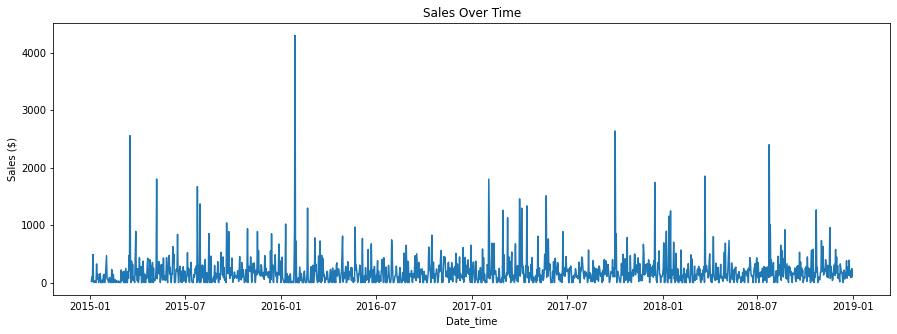

In [ ]:
# plot the sales over time (by order date)
plt.figure(figsize=(15,5))
plt.plot(daily_df)
plt.xlabel('Date_time')
plt.ylabel('Sales ($)')
plt.title('Sales Over Time')
plt.show()


In [ ]:
# Let's decompose the data and look at trend, seasonality and cycle out individually.
decomposition = tsa.seasonal_decompose(daily_df_vis, model='additive')

In [ ]:
daily_df_vis["Trend"] = decomposition.trend
daily_df_vis["Seasonal"] = decomposition.seasonal
daily_df_vis["Residual"] = decomposition.resid

daily_df_vis.head(10)

,Sales,Trend,Seasonal,Residual
Order Date,,,,
2015-01-03,16.448000,NaN,17.221408,NaN
2015-01-04,96.020000,NaN,42.133579,NaN
2015-01-05,19.536000,NaN,8.979948,NaN
2015-01-06,489.677778,97.933254,12.866588,378.877935
2015-01-07,43.579000,99.499968,22.162731,-78.083700
2015-01-08,0.000000,87.202825,-39.578364,-47.624462
2015-01-09,20.272000,84.411968,-63.785891,-0.354078
2015-01-10,27.415000,60.611182,17.221408,-50.417590
2015-01-11,9.940000,63.237039,42.133579,-95.430618


In [ ]:
cols = ["Trend", "Seasonal", "Residual"]

fig = make_subplots(rows=3, cols=1, subplot_titles=cols)

for i, col in enumerate(cols):
    fig.add_trace(
        go.Scatter(x=daily_df_vis.index, y=daily_df_vis[col]),
        row=i+1,
        col=1
    )

fig.update_layout(height=800, width=1200, showlegend=False)
fig.show()

* The sales trend was not stable
* Difficult to read seasonality since it's set as daily.
* I don't see a clear pattern in the residuals.

# 3. Build Time Series Model

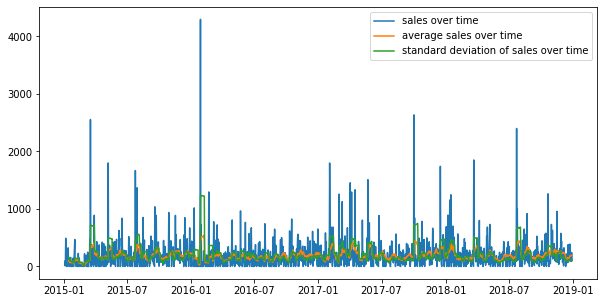

In [ ]:
# Check if time series data is staionary.
mean = daily_df_vis.rolling(window=12).mean()['Sales']
std = daily_df_vis.rolling(window=12).std()['Sales']
plt.figure(figsize=(10,5))
plt.plot(daily_df_vis.index,daily_df_vis['Sales'],label='sales over time')

plt.plot(mean,label='average sales over time')

plt.plot(std,label='standard deviation of sales over time')
plt.legend()
plt.show()

The mean and standard deviation seems to be constant

In [ ]:
# Perform Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(daily_df_vis['Sales'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -24.952364
p-value: 0.000000


P value is less than 0.05 so we can reject the null hypothesis that the time series data is staionary

In [ ]:
import itertools
p = d = q = range(0, 2) 
pdq = list(itertools.product(p, d, q))
seasonal_pdq_comb = [(i[0], i[1], i[2], 12) for i in list(itertools.product(p, d, q))] #for loop for creating combinations of seasonal parameters of SARIMA
print('Examples of parameter combinations for Seasonal ARIMA:')
print('SARIMA: {} x {}'.format(pdq[1], seasonal_pdq_comb[1]))
print('SARIMA: {} x {}'.format(pdq[1], seasonal_pdq_comb[2]))
print('SARIMA: {} x {}'.format(pdq[2], seasonal_pdq_comb[3]))
print('SARIMA: {} x {}'.format(pdq[2], seasonal_pdq_comb[4]))

Examples of parameter combinations for Seasonal ARIMA:
SARIMA: (0, 0, 1) x (0, 0, 1, 12)
SARIMA: (0, 0, 1) x (0, 1, 0, 12)
SARIMA: (0, 1, 0) x (0, 1, 1, 12)
SARIMA: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
for parameters in pdq: #for loop for determining the best combination of seasonal parameters for SARIMA
    for seasonal_param in seasonal_pdq_comb:
        try:
            mod = sm.tsa.statespace.SARIMAX(daily_df,
                                            order=parameters,
                                            seasonal_param_order=seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False) #determines the AIC value of the model**
            results = mod.fit()
            print('SARIMA{}x{}12 - AIC:{}'.format(parameters, seasonal_param, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:21019.33733283006
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:21019.33733283006
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:21019.33733283006
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:21019.33733283006
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:21019.33733283006
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:21019.33733283006
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:21019.33733283006
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:21019.33733283006
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:20881.262386481925
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:20881.262386481925
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:20881.262386481925
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:20881.262386481925
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:20881.262386481925
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:20881.262386481925
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:20881.262386481925
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:20881.262386481925
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:21364.824871446683
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2

Seems like (1,1,1) and (1,1,1,12) is the optimal combination

In [ ]:
mod = sm.tsa.statespace.SARIMAX(daily_df,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0292      0.025      1.185      0.236      -0.019       0.077
ma.L1         -1.0024      0.003   -301.692      0.000      -1.009      -0.996
sigma2      7.084e+04    888.352     79.748      0.000    6.91e+04    7.26e+04


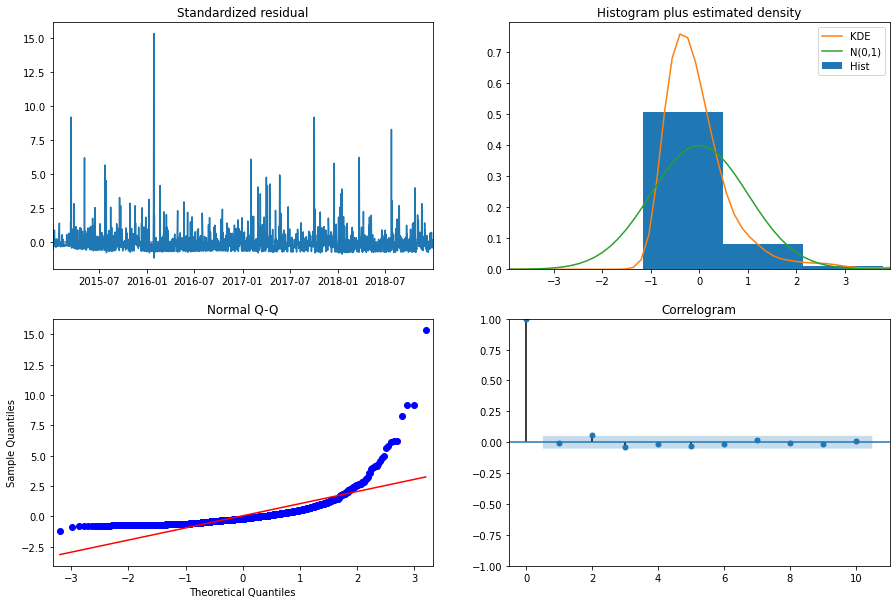

In [ ]:
results.plot_diagnostics(figsize=(15, 10))
plt.show()

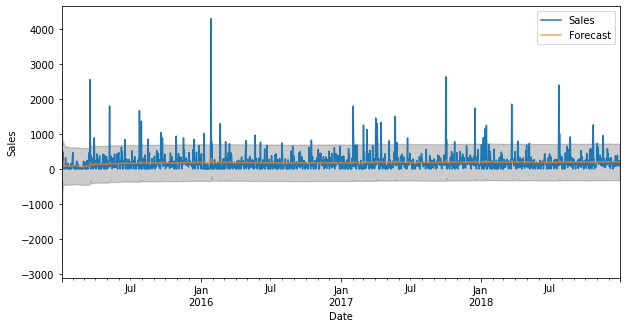

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2015-01-03'), dynamic=False)
pred_ci = pred.conf_int()

ax = daily_df['2015':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(10, 5))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()

plt.show()

In [ ]:
daily_df_forecasted = pred.predicted_mean
daily_df_actual = daily_df['Sales']

# Compute the mean square error
from sklearn.metrics import mean_squared_error
from math import sqrt

mse = mean_squared_error(daily_df_forecasted, daily_df_actual)
rmse = sqrt(mse)
print('The Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 266.86


In [ ]:
daily_df.describe()

,Sales
count,1458.000000
mean,191.252773
std,266.660238
min,0.000000
25%,39.905000
50%,129.688400
75%,247.235143
max,4297.644000


RMSE tells us that our model was able to forecast the average daily sales within 266.86 of the actual sales.

Predict the sales in the next 7 days

In [ ]:
print(results.forecast(steps=7))

2018-12-31    197.063896
2019-01-01    199.840293
2019-01-02    199.921354
2019-01-03    199.923721
2019-01-04    199.923790
2019-01-05    199.923792
2019-01-06    199.923792
Freq: D, dtype: float64
